## Introducción

Este trabajo aborda un problema de regresión en el que se pretende predecir el **índice de rendimiento académico** de estudiantes universitarios a partir de un conjunto de variables que reflejan hábitos de estudio, descanso, prácticas previas y participación extracurricular.

El dataset incluye variables numéricas y categóricas que permiten explorar la relación entre estos factores y el desempeño académico global de los estudiantes.

---

### Objetivo

El objetivo principal de este proyecto es:

> **Desarrollar un modelo de regresión basado en redes neuronales que permita predecir con precisión el rendimiento académico de un estudiante, utilizando como entrada sus características personales y académicas.**





## Preparación del entorno

In [108]:
# Se importan librerías a utilizar

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import mean_absolute_error, r2_score

## Análisis Exploratorio

In [88]:
# Carga del dataset a trabajar

datos = pd.read_csv('Student_Performance.csv')

In [89]:
datos

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [90]:
# Codificación binaria de la variable categórica 'Extracurricular Activities'

datos['Extracurricular Activities'] = datos['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

In [91]:
# Se renombran las columnas del dataset para facilitar el uso

datos = datos.rename(columns={'Extracurricular Activities': 'extra_act',
                              'Sample Question Papers Practiced': 'practice_count',
                              'Sleep Hours': 'hr_sleep',
                              'Performance Index': 'y',
                              'Hours Studied' : 'hr_studied',
                              'Previous Scores': 'prev_score'})

In [92]:
# Verificación de nulos

datos.isna().sum()

,0
hr_studied,0
prev_score,0
extra_act,0
hr_sleep,0
practice_count,0
y,0


No se registran valores nulos para el dataset en ninguna de las variables.

In [93]:
# Resumen estadístico de variables numéricas

datos.describe()

,hr_studied,prev_score,extra_act,hr_sleep,practice_count,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


La mayoría de los estudiantes estudian entre 3 y 7 horas diarias (hr_studied), con una media cercana a 5.

Las puntuaciones previas (prev_score) tienen una media de 69.

Casi el 50% participa en actividades extracurriculares (extra_act ≈ 0.5), por lo que hay una distribución bastante equilibrada.

El sueño promedio (hr_sleep) ronda las 6.5 horas, pero hay estudiantes que duermen muy poco (mínimo 4).

En cuanto a la target, los valores van desde 10 hasta 100, con una media de 55.

In [94]:
# Separación del conjunto de datos en variables independientes (X) y variable target (y)

X = datos.drop('y', axis=1)
y = datos['y']
y

,y
0,91.0
1,65.0
2,45.0
3,36.0
4,66.0
...,...
9995,23.0
9996,58.0
9997,74.0
9998,95.0


In [95]:
# División del conjunto de datos en entrenamiento y test (80% - 20%)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
)

In [96]:
# Dimensiones de conjuntos

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000,), (2000,))

In [97]:
# Se escalan las variables numéricas (excepto 'extra_act' que ya está en formato binario)
columnas_a_escalar = X_train.columns.drop('extra_act')

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[columnas_a_escalar] = scaler.fit_transform(X_train[columnas_a_escalar])
X_test_scaled = X_test.copy()
X_test_scaled[columnas_a_escalar] = scaler.transform(X_test[columnas_a_escalar])

# Escalado de la variable objetivo 'y' a un rango entre 0 y 1
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [98]:
X_train_scaled

,hr_studied,prev_score,extra_act,hr_sleep,practice_count
9254,0.006455,-1.183844,0,0.269888,0.134041
1561,-1.149747,-1.241506,1,0.269888,0.483562
1670,-1.149747,0.661318,0,0.269888,-0.914520
6087,-1.149747,-1.356828,0,-0.318906,-1.264041
6669,1.162658,-1.299167,0,1.447477,-1.613561
...,...,...,...,...,...
5734,1.162658,-1.126183,1,-0.318906,0.483562
5191,-0.378946,-0.088279,0,1.447477,-0.565000
5390,1.548059,-1.241506,0,0.269888,0.483562
860,-1.535148,-1.299167,0,1.447477,-1.613561


In [99]:
y_train_scaled

array([[0.28888889],
       [0.16666667],
       [0.54444444],
       ...,
       [0.37777778],
       [0.11111111],
       [0.15555556]])

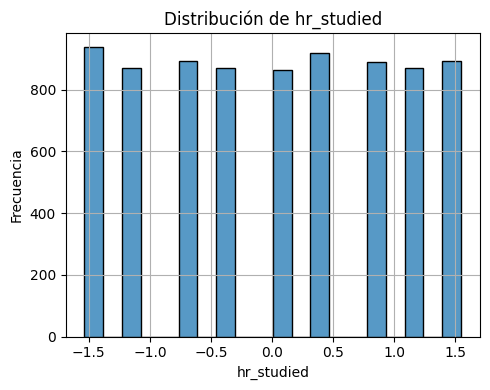

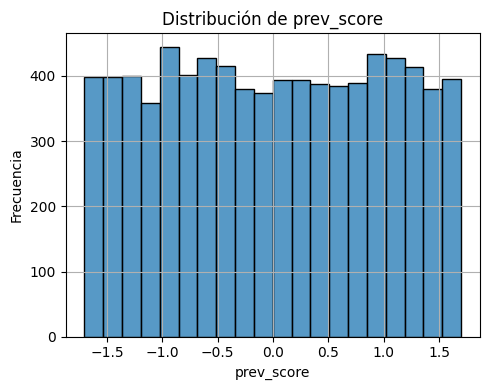

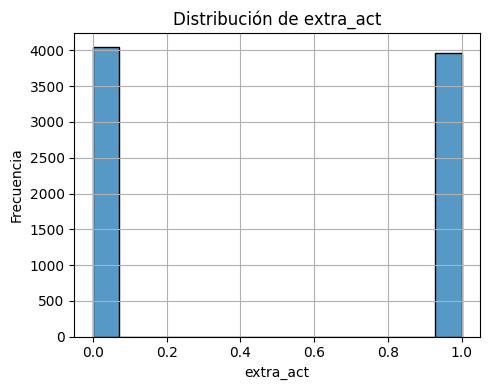

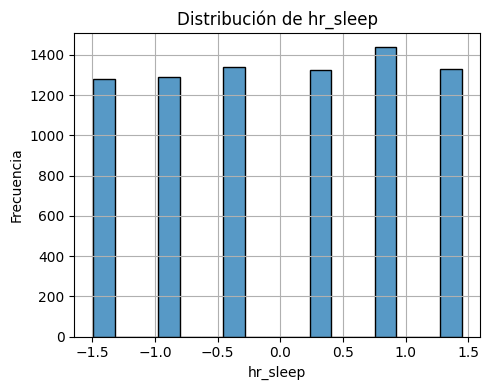

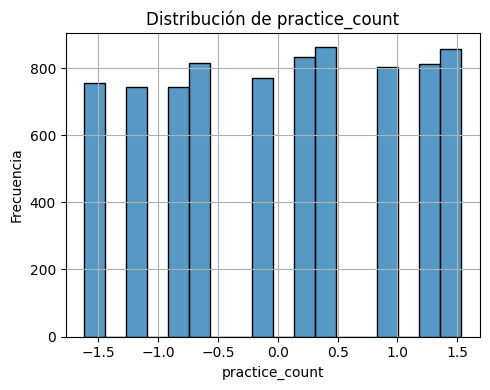

In [100]:
# Distribución de las variables numéricas

for var in X_train_scaled.columns:
    plt.figure(figsize=(5, 4))
    sns.histplot(X_train_scaled[var], kde=False)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()

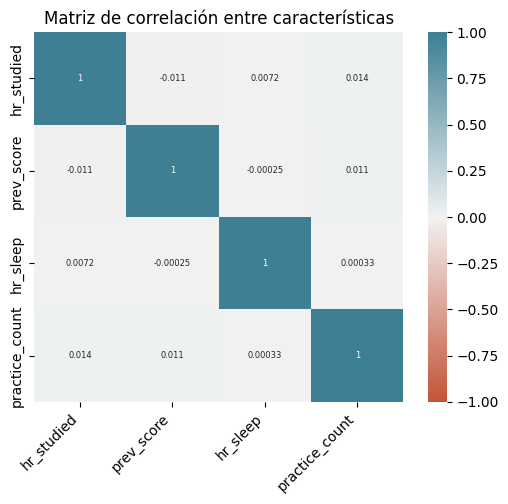

In [101]:
# Cálculo y visualización de la matriz de correlación entre variables

df_corr = X_train_scaled.drop(['extra_act'], axis=1)
corr = df_corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    annot_kws={'size': 6}
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Matriz de correlación entre características")
plt.show()

Las variables numéricas muestran correlaciones muy bajas entre sí, con valores cercanos a 0.

Por lo que no existe multicolinealidad fuerte entre las variables predictoras, lo cual es positivo, ya que cada variable puede aportar información diferente a la predicción.

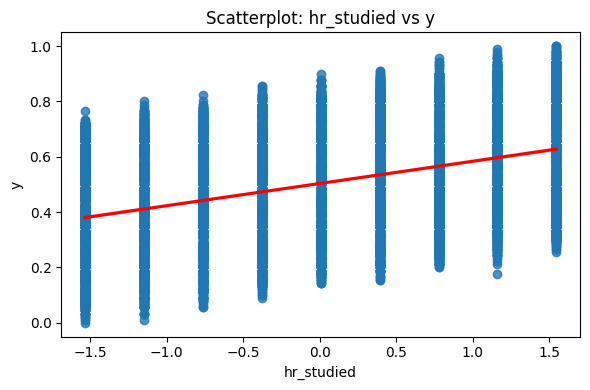

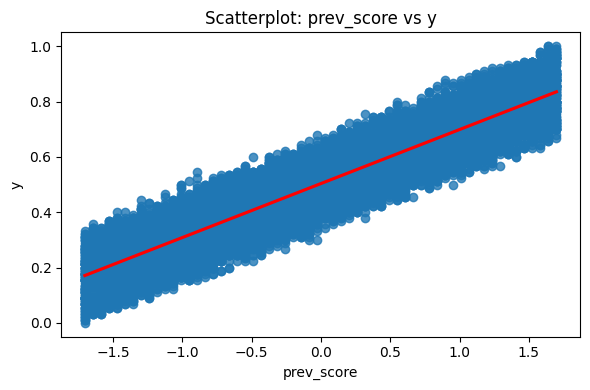

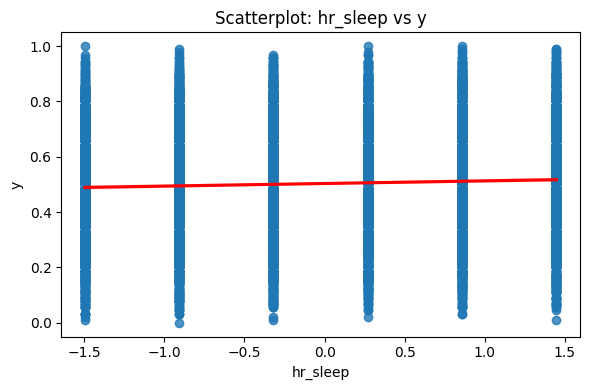

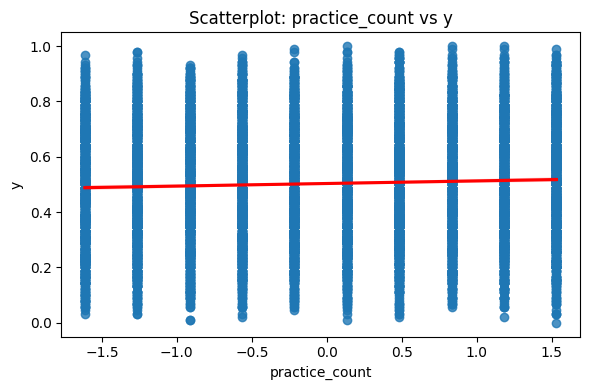

In [102]:
# Visualización de la relación entre cada variable y la variable objetivo

for feature in df_corr:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=X_train_scaled, x=feature, y=y_train_scaled, line_kws={'color': 'red'})
    plt.title(f'Scatterplot: {feature} vs y')
    plt.xlabel(feature)
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

Las variables hr_studied y prev_score tienen una tendencia positiva, siendo la de hr_studied algo débil y muy dispersa por lo que por si sola no lograría explicar bien el modelo. Por el contrario prev_score parece tener una correlación más fuerte y positiva.

En el resto de variables los puntos están muy dispersos verticalmente, sin una tendencia clara.
La línea de regresión roja es prácticamente horizontal, lo que indica que no hay correlación entre la variable practice_count y la variable objetivo y.

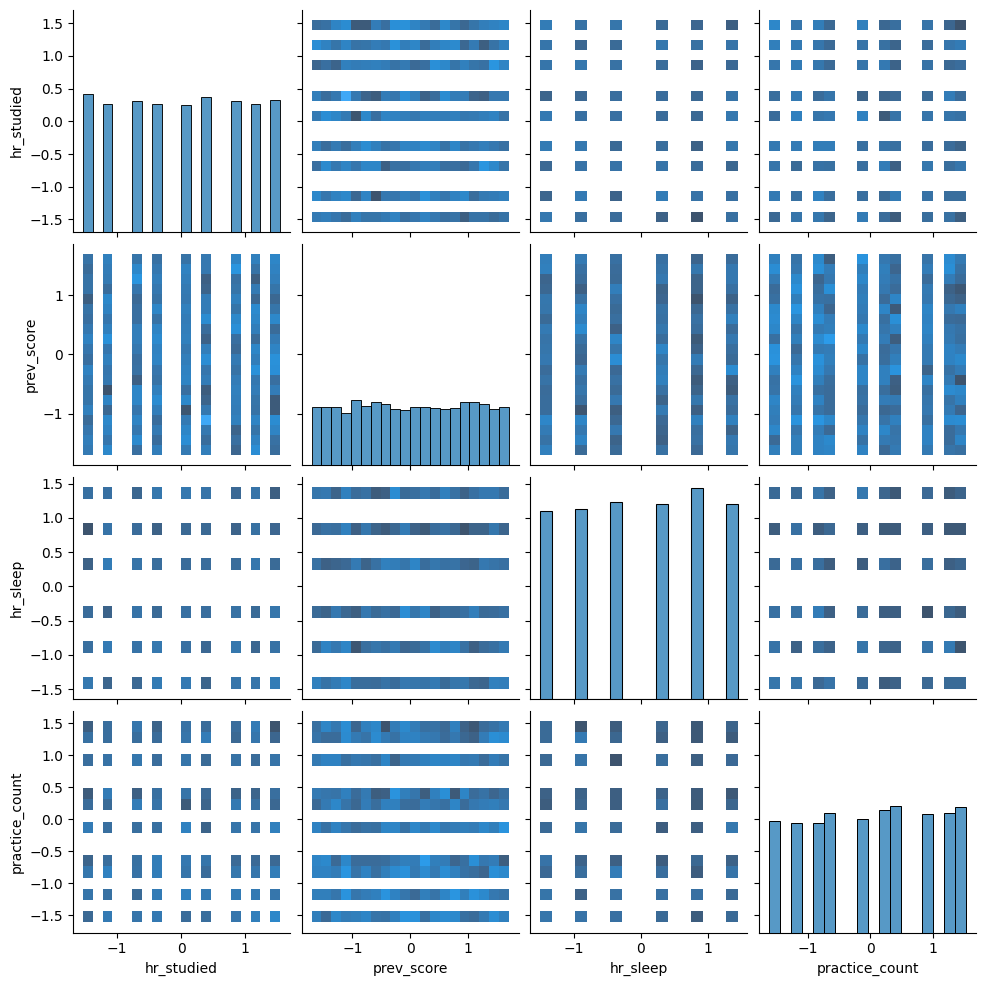

In [103]:
# Visualización conjunta de las distribuciones y relaciones entre las variables predictoras

sns.pairplot(df_corr, kind="hist")
plt.show()

## Definición de modelo y entrenamiento

In [104]:
# Definición del modelo de red neuronal solo con las variables prev_score y hr_studied

X_train_scaled = X_train_scaled[['prev_score','hr_studied']]
X_test_scaled = X_test_scaled[['prev_score','hr_studied']]

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(1)
])
model.summary()

history = model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train_scaled, y_train_scaled, epochs=20, batch_size=32, validation_split=0.2)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5004 - mae: 0.5614 - val_loss: 0.0239 - val_mae: 0.1319
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - mae: 0.1134 - val_loss: 0.0055 - val_mae: 0.0612
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - mae: 0.0501 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0258 - val_loss: 9.2815e-04 - val_mae: 0.0240
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.5407e-04 - mae: 0.0244 - val_loss: 8.9925e-04 - val_mae: 0.0237
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.1394e-04 - mae: 0.0238 - val_loss: 8.7825e-04 - val_mae: 0.0234
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8332e-04 - mae: 0.0233 - val_loss: 8.5501e-04 - val_mae: 0.0232
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.6643e-04 - mae: 0.0231 - val_loss: 8.3671e-04 - val_mae: 0.0229
Epoch 9/20
200/200 ━

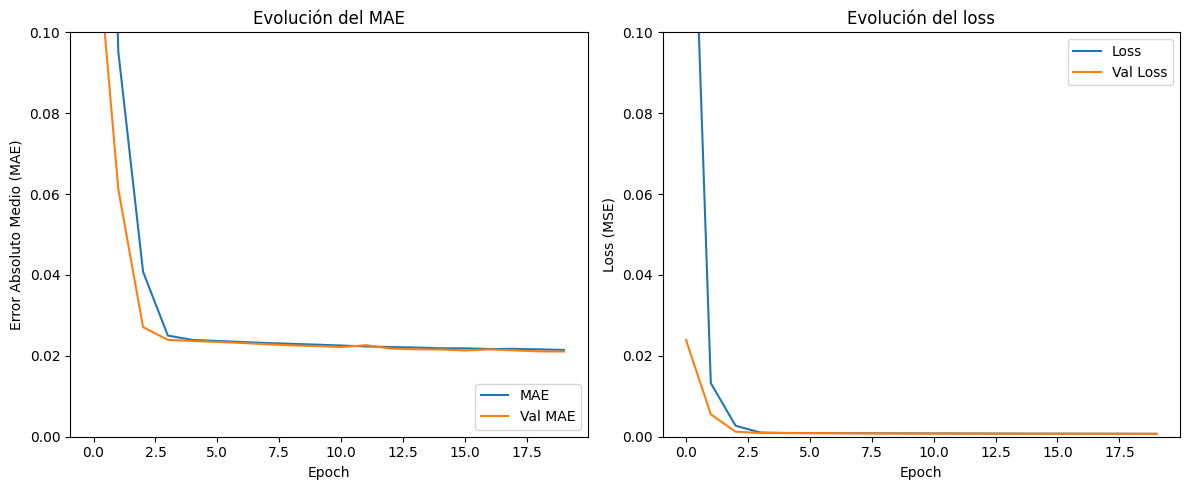

In [105]:
# Gráficos de evolución de pérdida y MAE

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.ylim([0, 0.1])
plt.title('Evolución del MAE')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.ylim([0, 0.1])
plt.title('Evolución del loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


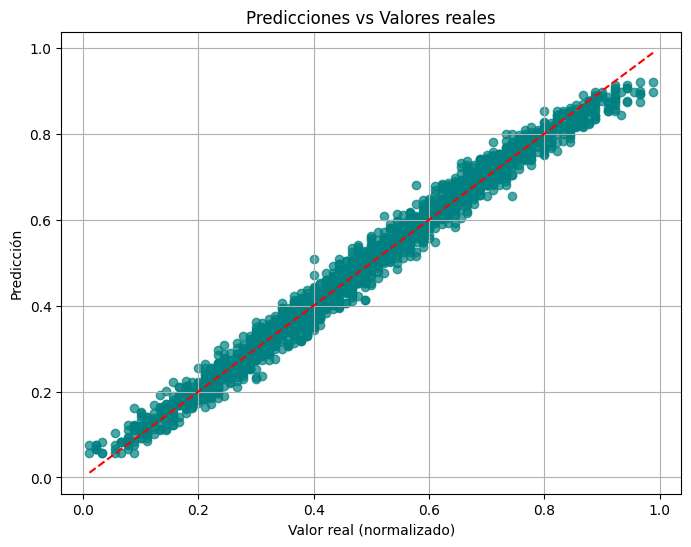

In [106]:
# Predicciones y comparación con valores reales

y_pred = model.predict(X_test_scaled).flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_scaled, y_pred, alpha=0.7, color='teal')
plt.plot([y_test_scaled.min(), y_test_scaled.max()],
         [y_test_scaled.min(), y_test_scaled.max()], 'r--')
plt.xlabel('Valor real (normalizado)')
plt.ylabel('Predicción')
plt.title('Predicciones vs Valores reales')
plt.grid(True)
plt.show()

In [109]:
# Invertir la escala de y (desnormalizar)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Evaluación con métricas reales
mae_real = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE en escala original: {mae_real:.2f}")
print(f"R²: {r2:.2f}")

MAE en escala original: 1.91
R²: 0.98


Conclusión Final

En este trabajo se ha desarrollado un modelo de regresión utilizando una red neuronal para predecir el rendimiento académico de estudiantes universitarios, basándose únicamente en las variables prev_score (nota previa) y hr_studied (horas de estudio), ya que demostraron ser las más relevantes en el análisis exploratorio inicial.

Tras entrenar el modelo durante 20 épocas, con dos capas densas de 32 y 16 neuronas de activaciones sigmoid (dando como resultado 641 parámetros) se obtuvieron los siguientes resultados: una pérdida media cuadrática (MSE) de 0.00065 y un error absoluto medio (MAE) de 0.0205 en el conjunto de validación. Ambos resultados similares para los conjuntos de entrenamiento y validación por lo que sugiere que el modelo no está overfiteando y nos indican un buen rendimiento del modelo empleado. La incorporación de todas las variables no mejoró significativamente en los resultados por lo que se decide no incorporarlas.

Los gráficos de aprendizaje muestran una evolución estable sin señales de sobreajuste, lo cual sugiere que el modelo está generalizando correctamente sobre datos no vistos.
La gráfica de predicciones frente a valores reales también respalda esta conclusión, ya que los puntos se alinean adecuadamente respecto a la diagonal ideal.

Finalmente, al desnormalizar los resultados y calcular las métricas en su escala original, se obtuvo un MAE de 1.91 puntos, lo que indica un error medio muy bajo en términos prácticos. Además, el modelo alcanzó un coeficiente de determinación R² = 0.98, lo cual explica casi toda la variabilidad del rendimiento académico en función de las variables seleccionadas.

El modelo final resulta simple y efectivo, cumpliendo con el objetivo planteado.